In [5]:
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow
from tqdm import tqdm
%matplotlib inline

# Read Data

In [2]:
df = pd.read_csv('icml_face_data.csv')

In [3]:
df.head(3)

,emotion,Usage,pixels
0,0,Training,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...
1,0,Training,151 150 147 155 148 133 111 140 170 174 182 15...
2,2,Training,231 212 156 164 174 138 161 173 182 200 106 38...


In [4]:
df['emotion'].value_counts()

3    8989
6    6198
4    6077
2    5121
0    4953
5    4002
1     547
Name: emotion, dtype: int64

# Data Pre-Processing

In [6]:
df.drop(df[df['emotion']==1].index.tolist(), inplace=True)
df.reset_index(inplace=True, drop=True)
df = df.sample(frac=1).reset_index(drop=True)

df['array'] = df[' pixels'].apply(lambda x: np.fromstring(x, dtype=int, sep=' '))
df['array'] = df['array'].apply(lambda x: np.reshape(x,(48,48)))
df['array'] = df['array'].apply(lambda x: x/255.)
df['emotion_text'] = df['emotion'].map({0:'Angry', 2:'Fear', 3:'Happy', 4:'Sad', 5:'Surprise', 6:'Neutral'})
df['emotion'] = df['emotion'].map({0:0, 2:1, 3:2, 4:3, 5:4, 6:5})

In [7]:
df.isnull().sum()

emotion         0
 Usage          0
 pixels         0
array           0
emotion_text    0
dtype: int64

In [8]:
df['emotion_text'].value_counts()

Happy       8989
Neutral     6198
Sad         6077
Fear        5121
Angry       4953
Surprise    4002
Name: emotion_text, dtype: int64

In [9]:
df.head(3)

,emotion,Usage,pixels,array,emotion_text
0,2,Training,72 65 39 30 47 103 149 156 163 171 175 181 184...,"[[0.2823529411764706, 0.2549019607843137, 0.15...",Happy
1,4,Training,254 254 253 253 171 99 105 101 84 92 118 141 1...,"[[0.996078431372549, 0.996078431372549, 0.9921...",Surprise
2,0,PrivateTest,194 189 187 178 165 132 64 31 46 45 23 20 25 3...,"[[0.7607843137254902, 0.7411764705882353, 0.73...",Angry


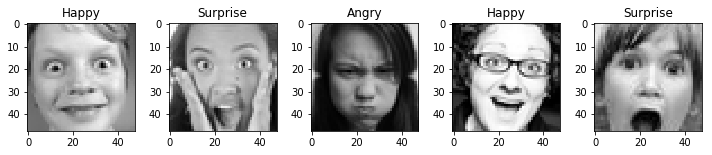

In [10]:
rows = 1
cols = 5
axes=[]
fig=plt.figure(figsize=(10,10))

for a in range(rows*cols):
    axes.append(fig.add_subplot(rows, cols, a+1))
    subplot_title=(df.loc[a,'emotion_text'])
    axes[-1].set_title(subplot_title)
    plt.imshow(df.loc[a,'array'], cmap='gray')
    
fig.tight_layout()    
plt.show()

# Model Data Preparation

In [11]:
from sklearn.model_selection import train_test_split

In [12]:
X = [value[1][-2] for value in tqdm(df.iterrows())]
X = np.array(X)
X = np.reshape(X, (-1,48,48,1))

y = [value[1][0] for value in tqdm(df.iterrows())]
y = np.array(y)

35340it [00:03, 9550.72it/s]
35340it [00:03, 9775.23it/s]


In [13]:
X.shape, y.shape

((35340, 48, 48, 1), (35340,))

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, random_state=42)

# Model Preparation

In [15]:
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Flatten, Dropout, BatchNormalization, LSTM, Flatten, Reshape, Permute
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import Sequential, load_model

In [16]:
model_checkpoint_callback = ModelCheckpoint(filepath='best_model.h5', save_weights_only=True,
                                            monitor='val_acc', mode='max', save_best_only=True,verbose=1)

model_earlystopping_callback = EarlyStopping(monitor='val_loss', patience=2)

model_plateau_callback = ReduceLROnPlateau(monitor='val_loss', patience=1)

callback_list = [model_checkpoint_callback, model_earlystopping_callback, model_plateau_callback]

In [17]:
#model.add(Reshape((64, -1)))
#model.add(Permute((2, 1)))
#CNN and RNN Connection Layers 

model = Sequential()

model.add(Conv2D(64, (3,3), activation='relu', input_shape = (48,48,1)))
model.add(MaxPool2D((2,2)))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Conv2D(128, (5,5), activation='relu'))
model.add(MaxPool2D((2,2)))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Conv2D(256, (3,3), activation='relu'))
model.add(MaxPool2D((2,2)))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Flatten())

model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Dense(6, activation='softmax'))

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model.load_weights('best_model.h5')

In [18]:
model.fit(X_train, y_train, batch_size=16, epochs=30, verbose=1, callbacks=callback_list, validation_split=0.1)

Train on 28625 samples, validate on 3181 samples
Epoch 1/30
28625/28625 [==============================] - 509s 18ms/step - loss: 1.7478 - acc: 0.3141 - val_loss: 1.5938 - val_acc: 0.3741

Epoch 00001: val_acc improved from -inf to 0.37410, saving model to best_model.h5
Epoch 2/30
28625/28625 [==============================] - 466s 16ms/step - loss: 1.4253 - acc: 0.4355 - val_loss: 1.3500 - val_acc: 0.4671

Epoch 00002: val_acc improved from 0.37410 to 0.46715, saving model to best_model.h5
Epoch 3/30
28625/28625 [==============================] - 449s 16ms/step - loss: 1.3146 - acc: 0.4844 - val_loss: 1.1954 - val_acc: 0.5278

Epoch 00003: val_acc improved from 0.46715 to 0.52782, saving model to best_model.h5
Epoch 4/30
28625/28625 [==============================] - 452s 16ms/step - loss: 1.2497 - acc: 0.5151 - val_loss: 1.1643 - val_acc: 0.5454

Epoch 00004: val_acc improved from 0.52782 to 0.54543, saving model to best_model.h5
Epoch 5/30
28625/28625 [==============================

# Model's Result Exploration

In [19]:
df_model = pd.DataFrame(model.history.history)

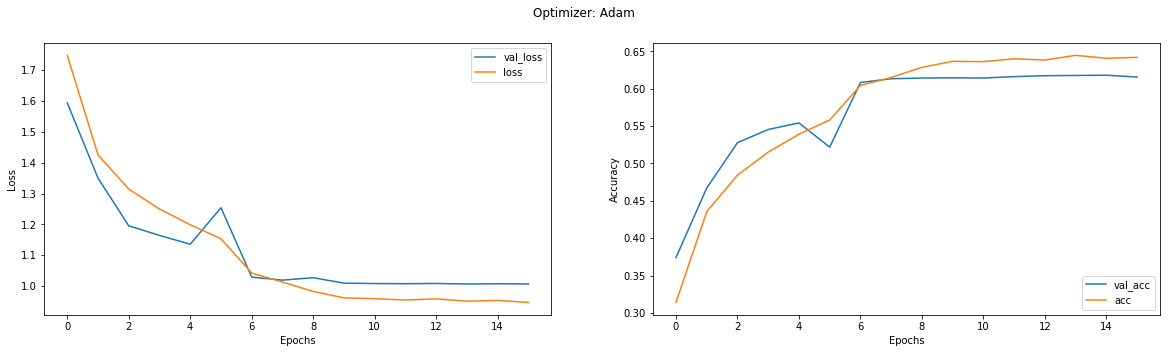

In [20]:
plt.figure(figsize=(20,5))
plt.subplot(1,2,1)
plt.suptitle('Optimizer: Adam')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.plot(df_model['val_loss'])
plt.plot(df_model['loss'])
plt.legend(loc=1)

plt.subplot(1,2,2)
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.plot(df_model['val_acc'])
plt.plot(df_model['acc'])
plt.legend(loc=4)

In [18]:
predictions = model.predict_classes(X_test)

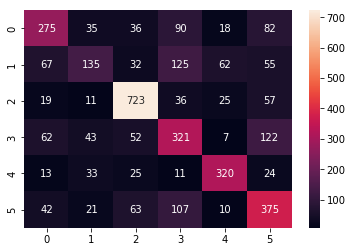

In [22]:
from sklearn.metrics import confusion_matrix, classification_report

cf_matrix = confusion_matrix(y_test, predictions)
sns.heatmap(cf_matrix, annot=True, fmt='g')

In [23]:
print(classification_report(y_test, predictions))

             precision    recall  f1-score   support

          0       0.58      0.51      0.54       536
          1       0.49      0.28      0.36       476
          2       0.78      0.83      0.80       871
          3       0.47      0.53      0.49       607
          4       0.72      0.75      0.74       426
          5       0.52      0.61      0.56       618

avg / total       0.60      0.61      0.60      3534



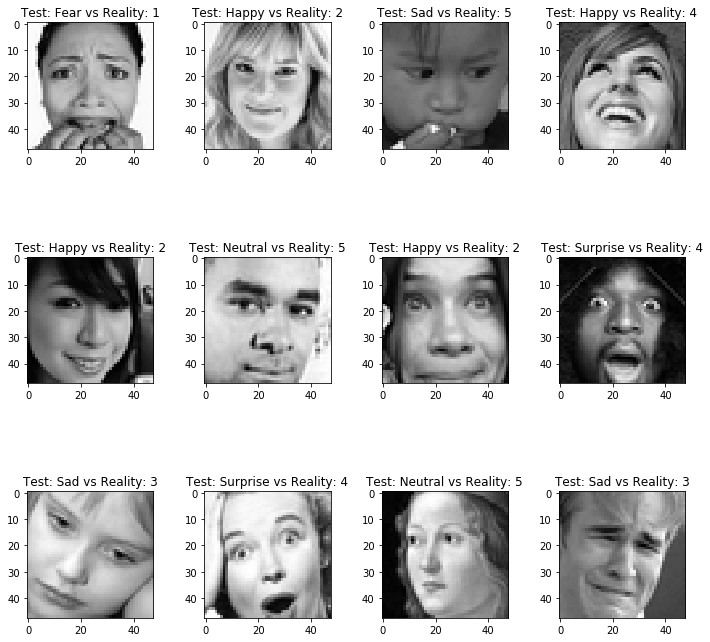

In [19]:
width=8
height=8
rows = 3
cols = 4
axes=[]
fig=plt.figure(figsize=(10,10))

for a in range(rows*cols):
    b = np.reshape(X_test[a], (48,48))
    axes.append(fig.add_subplot(rows, cols, a+1))
    if predictions[a] == 0: text_pred = subplot_title=('Test: Angry vs Reality: {}'.format(y_test[a]))
    if predictions[a] == 1: text_pred = subplot_title=('Test: Fear vs Reality: {}'.format(y_test[a]))
    if predictions[a] == 2: text_pred = subplot_title=('Test: Happy vs Reality: {}'.format(y_test[a]))
    if predictions[a] == 3: text_pred = subplot_title=('Test: Sad vs Reality: {}'.format(y_test[a]))
    if predictions[a] == 4: text_pred = subplot_title=('Test: Surprise vs Reality: {}'.format(y_test[a]))
    if predictions[a] == 5: text_pred = subplot_title=('Test: Neutral vs Reality: {}'.format(y_test[a]))
    axes[-1].set_title(subplot_title)  
    plt.imshow(b, cmap='gray')
fig.tight_layout()    
plt.show()

# {0:'Angry', 1:'Fear', 2:'Happy', 3:'Sad', 4:'Surprise', 5:'Neutral'})

# Real Time Predictions

In [22]:
img_list = [] 
cap = cv2.VideoCapture(0)

color = (255, 0, 0)
thickness = 2

font = cv2.FONT_HERSHEY_SIMPLEX
last_pred = [0]

while True:
    
    # Capture frame-by-frame
    ret, frame = cap.read()
    
    # Our operations on the frame come here
    
    start_point = (frame.shape[1]//3,frame.shape[0]//3)
    end_point = (frame.shape[1] * 3 // 4, frame.shape[0] * 3 // 4)
    
    #gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    colored_frame = cv2.rectangle(frame, start_point, end_point, color, thickness)
    
    img = cv2.rectangle(frame, start_point, end_point, color, thickness)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = cv2.resize(img, (48,48))
    img = img/255
    img = np.reshape(img, (-1,48,48,1))
    live_pred = model.predict_classes(img)
    
    if live_pred[0] == 0: text_pred = 'Angry'
    if live_pred[0] == 1: text_pred = 'Fear'
    if live_pred[0] == 2: text_pred = 'Happy'
    if live_pred[0] == 3: text_pred = 'Sad'
    if live_pred[0] == 4: text_pred = 'Surprise'
    if live_pred[0] == 5: text_pred = 'Neutral'
        
    # Display the resulting frame
    cv2.putText(colored_frame, text_pred, (230, 160), cv2.FONT_HERSHEY_PLAIN, 3, (0, 255, 255))
    cv2.imshow('frame',frame)
    
    # This command let's us quit with the "q" button on a keyboard.
    # Simply pressing X on the window won't work!
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
    img_list.append(frame)

# When everything done, release the capture and destroy the windows
cap.release()
cv2.destroyAllWindows()